# Introduction

# Libraries

In [34]:
import pandas as pd
import missingno as msno
import numpy as np
from scipy import stats
from pycaret.regression import *
from matplotlib import pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

# Data loading

In [35]:
# Sensor data is averaged and loaded every 5 minutes from March 18, 2022, to August 12, 2022
brine_storage=pd.read_csv('brine_storage.csv')
so2_generation=pd.read_csv('sulfur_dioxide_generation.csv')
conversion=pd.read_csv('conversion.csv')

# Data Cleaning and Processing

In [36]:
# We look at the data
brine_storage.head()

,ID_VARIABLE,PROCESS,TIMESTAMP,AVERAGE
0,NV_Yoduro_3.A6680FIT009.Val,Brine storage,2022-03-18 03:49:00.000,4.884375
1,NV_Yoduro_3.A6680FIT015.Val,Brine storage,2022-03-18 03:49:00.000,145.720032
2,NV_Yoduro_3.A6680FIT016.Val,Brine storage,2022-03-18 03:49:00.000,663.750000
3,NV_Yoduro_3.A6680FIT020.Val,Brine storage,2022-03-18 03:49:00.000,0.656250
4,NV_Yoduro_3.A6680LIT005.Val,Brine storage,2022-03-18 03:49:00.000,95.895470


In [37]:
# The PLC data is joined to have it all in one table
df=pd.concat([brine_storage,so2_generation,conversion],axis=0)
df.head()

,ID_VARIABLE,PROCESS,TIMESTAMP,AVERAGE
0,NV_Yoduro_3.A6680FIT009.Val,Brine storage,2022-03-18 03:49:00.000,4.884375
1,NV_Yoduro_3.A6680FIT015.Val,Brine storage,2022-03-18 03:49:00.000,145.720032
2,NV_Yoduro_3.A6680FIT016.Val,Brine storage,2022-03-18 03:49:00.000,663.750000
3,NV_Yoduro_3.A6680FIT020.Val,Brine storage,2022-03-18 03:49:00.000,0.656250
4,NV_Yoduro_3.A6680LIT005.Val,Brine storage,2022-03-18 03:49:00.000,95.895470


In [38]:
# The data type is reviewed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461383 entries, 0 to 496689
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ID_VARIABLE  1461383 non-null  object 
 1   PROCESS      1461383 non-null  object 
 2   TIMESTAMP    1461383 non-null  object 
 3   AVERAGE      1461383 non-null  float64
dtypes: float64(1), object(3)
memory usage: 55.7+ MB


In [39]:
# Timestamp data is required, the operation is performed
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461383 entries, 0 to 496689
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID_VARIABLE  1461383 non-null  object        
 1   PROCESS      1461383 non-null  object        
 2   TIMESTAMP    1461383 non-null  datetime64[ns]
 3   AVERAGE      1461383 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 55.7+ MB


<AxesSubplot:>

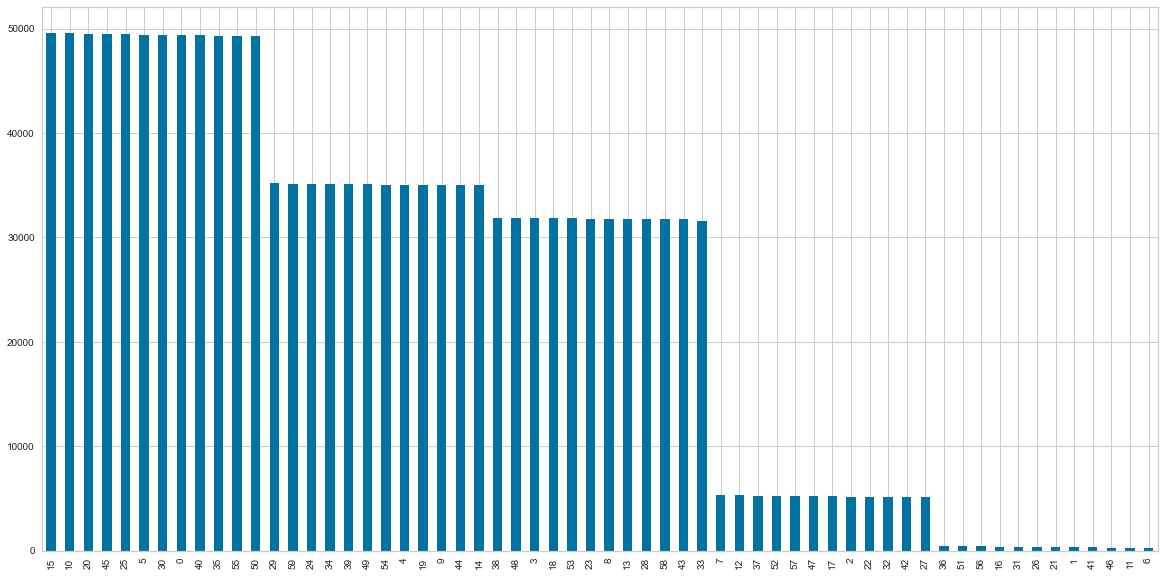

In [40]:
# We observe the temporal distribution of sampling
df.TIMESTAMP.apply(lambda x: x.minute).value_counts().plot(kind='bar',figsize=(20,10))

<AxesSubplot:>

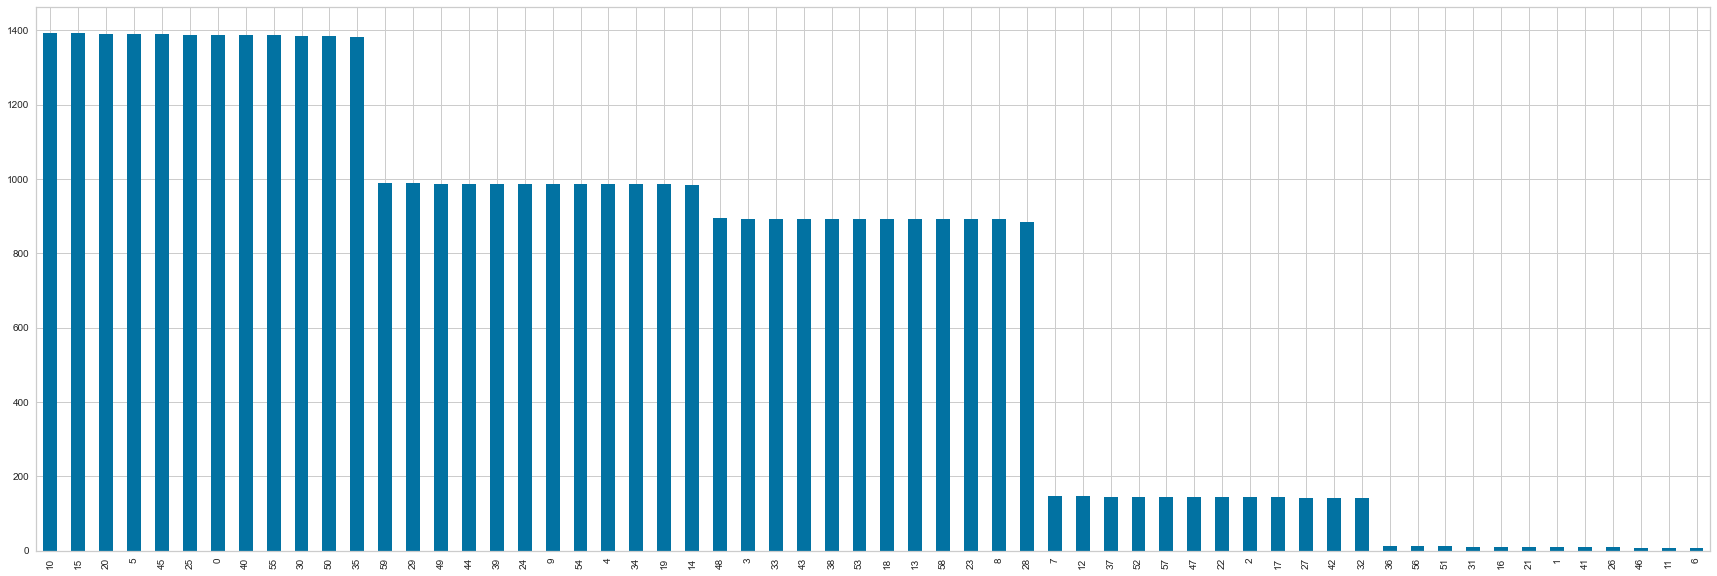

In [41]:
df.loc[df['ID_VARIABLE'].str.contains('AIT001')].TIMESTAMP.apply(lambda x: x.minute).value_counts().plot(kind='bar',figsize=(30,10))

In [42]:
# We sort the DataFrame by the columns 'TIMESTAMP' and 'VARIABLE ID' in descending order.
df.sort_values(by=['TIMESTAMP','ID_VARIABLE'],ascending=False).head()

,ID_VARIABLE,PROCESS,TIMESTAMP,AVERAGE
720994,NV_Yoduro_3.A6680WIT001.Val,Conversion,2022-08-12 07:43:00,2.869163
720995,NV_Yoduro_3.A6680TIT009.Val,Conversion,2022-08-12 07:43:00,408.049990
720996,NV_Yoduro_3.A6680TIT002.Val,Conversion,2022-08-12 07:43:00,290.200010
720993,NV_Yoduro_3.A6680WIT001.Val,Conversion,2022-08-12 07:38:00,3.034531
720985,NV_Yoduro_3.A6680TIT010.Val,Conversion,2022-08-12 07:38:00,50.025002


In [43]:
# We changed the column name 'Average'
df.rename(columns={'AVERAGE':'VALUE'},inplace=True)

In [44]:
# We pivot the table to have each Tag/Sensor as a regressor of the target variable
dataset_training=pd.pivot_table(df, values='VALUE', index=['TIMESTAMP'],columns=['ID_VARIABLE'], aggfunc=np.mean).reset_index()
dataset_training.head()

ID_VARIABLE,TIMESTAMP,NV_Yoduro_3.A6680AIT001.Val,NV_Yoduro_3.A6680AIT002.Val,NV_Yoduro_3.A6680FIT001.Val,NV_Yoduro_3.A6680FIT002.Val,NV_Yoduro_3.A6680FIT003.Val,NV_Yoduro_3.A6680FIT004.Val,NV_Yoduro_3.A6680FIT009.Val,NV_Yoduro_3.A6680FIT011.Val,NV_Yoduro_3.A6680FIT012.Val,...,NV_Yoduro_3.A6680PIT005.Val,NV_Yoduro_3.A6680PIT006.Val,NV_Yoduro_3.A6680PIT007.Val,NV_Yoduro_3.A6680PIT008.Val,NV_Yoduro_3.A6680PIT010.Val,NV_Yoduro_3.A6680TIT001.Val,NV_Yoduro_3.A6680TIT002.Val,NV_Yoduro_3.A6680TIT009.Val,NV_Yoduro_3.A6680TIT010.Val,NV_Yoduro_3.A6680WIT001.Val
0,2022-03-18 03:44:00,533.739929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-18 03:49:00,522.289856,1.81000,63.018749,33.712502,4.389750,4.86450,4.884375,282.095276,NaN,...,-7.623436,-2.884689,53.125,-4.616562,53.125,607.349976,389.600006,661.900024,NaN,NaN
2,2022-03-18 03:54:00,525.286804,1.77475,63.056252,33.646873,2.469375,NaN,5.478125,266.296722,NaN,...,-7.804062,-3.235313,NaN,-5.163750,NaN,608.150024,387.899994,663.299988,62.599998,2.573745
3,2022-03-18 03:59:00,524.586975,1.79850,62.559376,33.825001,2.652750,4.74525,5.506250,286.873718,NaN,...,-7.697811,-2.119686,NaN,-5.158436,NaN,608.650024,384.500000,660.950012,62.099998,2.561167
4,2022-03-18 04:04:00,545.377136,1.79600,64.818748,33.665627,2.661750,4.85550,5.078125,284.080933,NaN,...,-7.559689,-3.214062,NaN,-5.089375,NaN,608.150024,399.549988,662.200012,61.174999,2.408529


<AxesSubplot:>

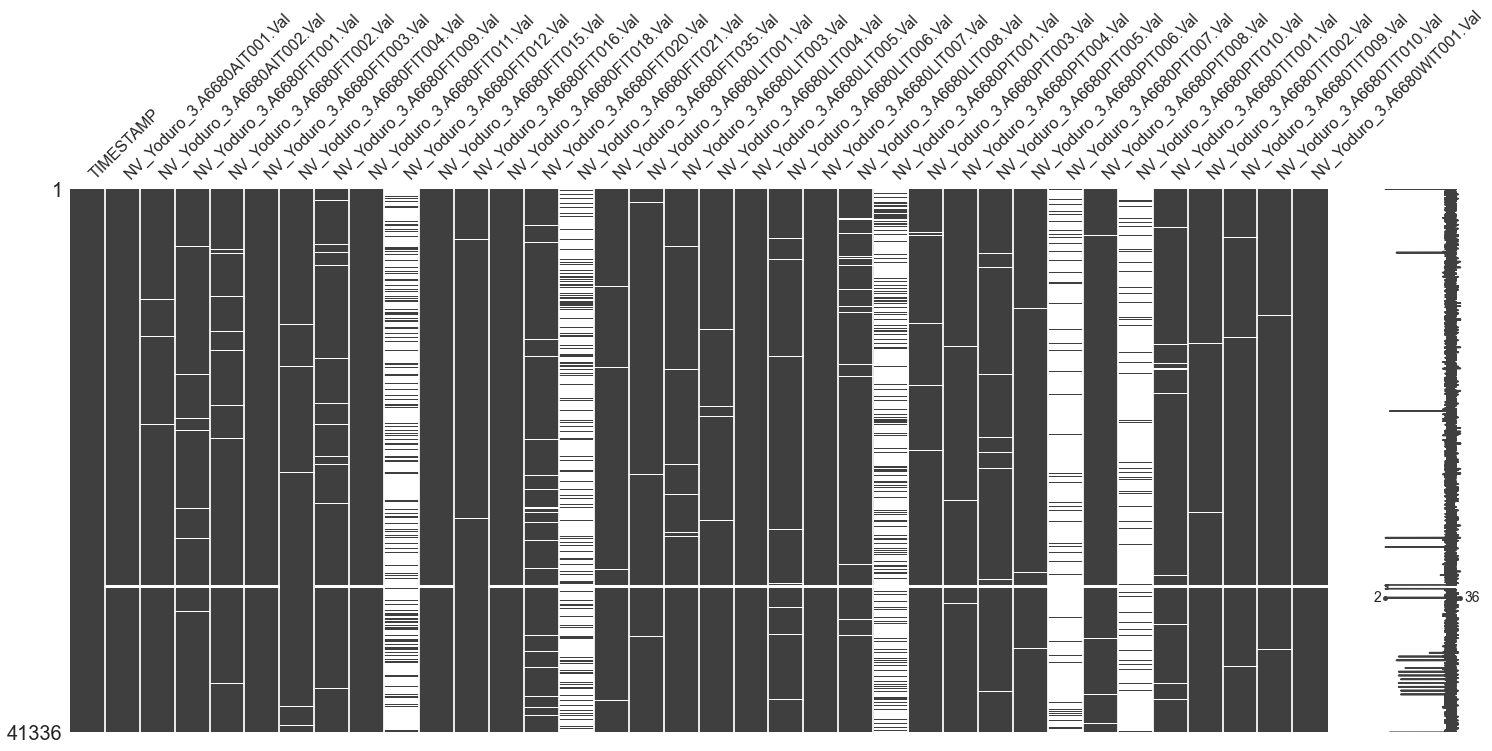

In [45]:
# We observe how complete the data is
msno.matrix(dataset_training)

In [46]:
dataset_training.drop(columns=['NV_Yoduro_3.A6680FIT021.Val','NV_Yoduro_3.A6680FIT012.Val','NV_Yoduro_3.A6680PIT001.Val',
                               'NV_Yoduro_3.A6680PIT007.Val','NV_Yoduro_3.A6680PIT010.Val',
                               'NV_Yoduro_3.A6680AIT002.Val'],inplace=True)

<AxesSubplot:>

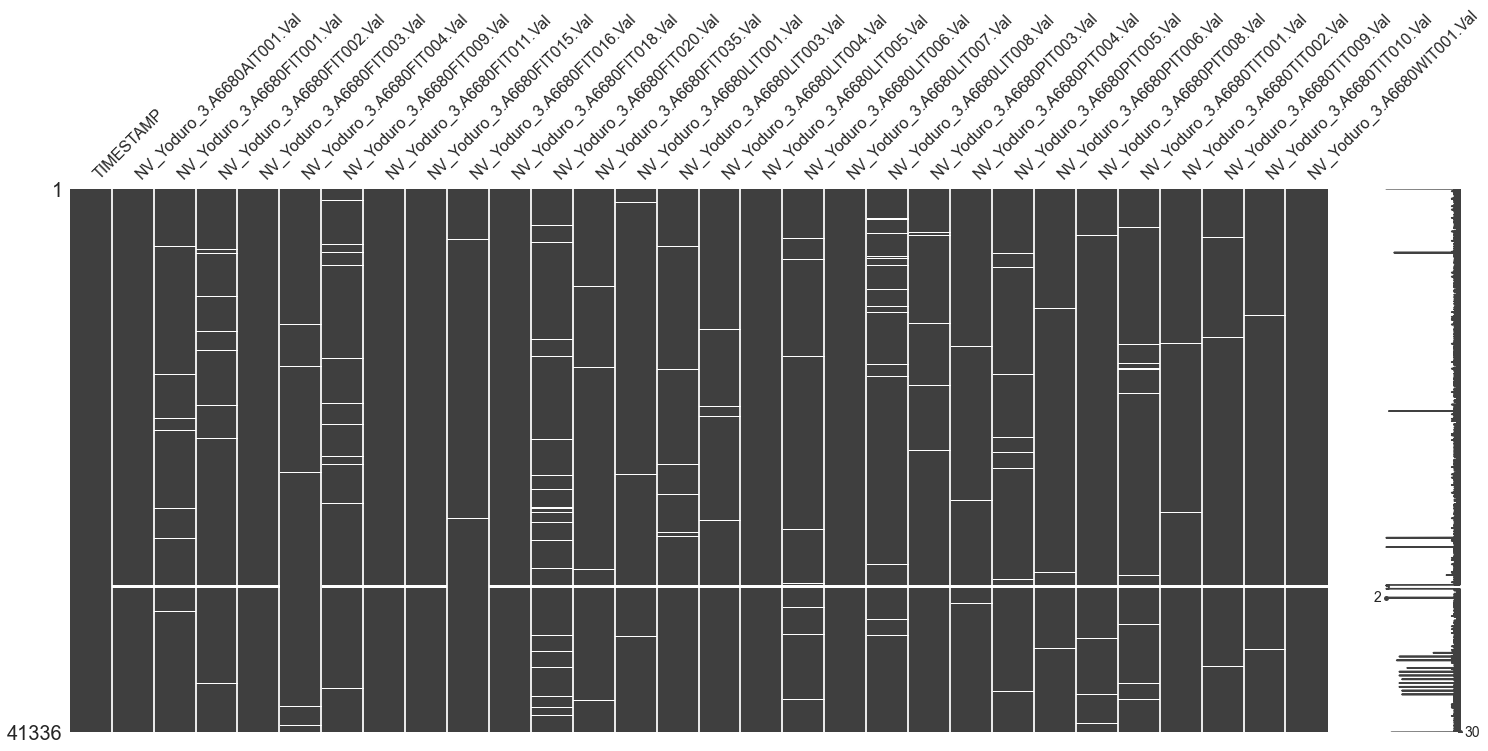

In [47]:
# It is checked how complete the data is
msno.matrix(dataset_training)

In [48]:
# We vote on null records, since the distribution of nulls is similar for all variables
dataset_training.dropna(inplace=True)

In [49]:
# The name of the columns is simplified
dataset_training.columns=[x.replace(".","").replace("Val","") for x in dataset_training.columns]

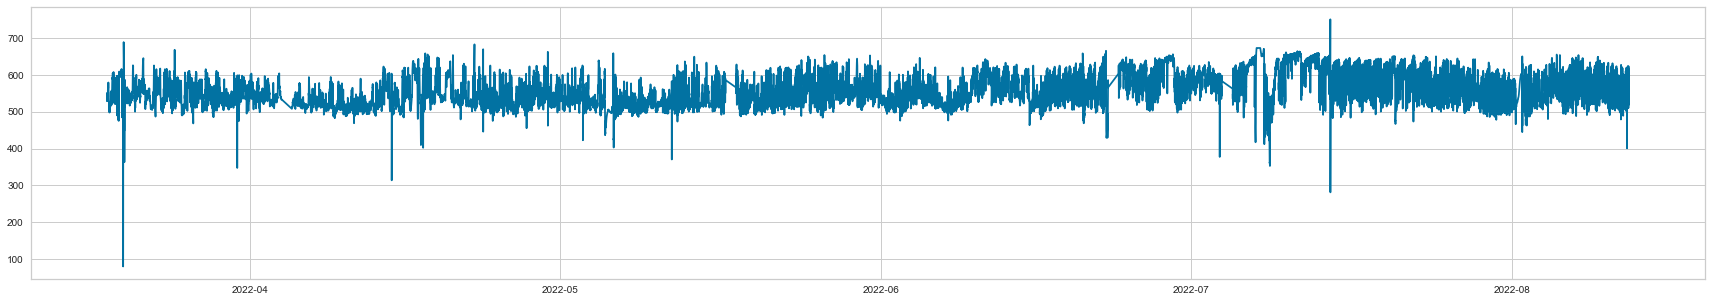

In [50]:
# ORP data is analyzed
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.plot(dataset_training['TIMESTAMP'],dataset_training["NV_Yoduro_3A6680AIT001"])

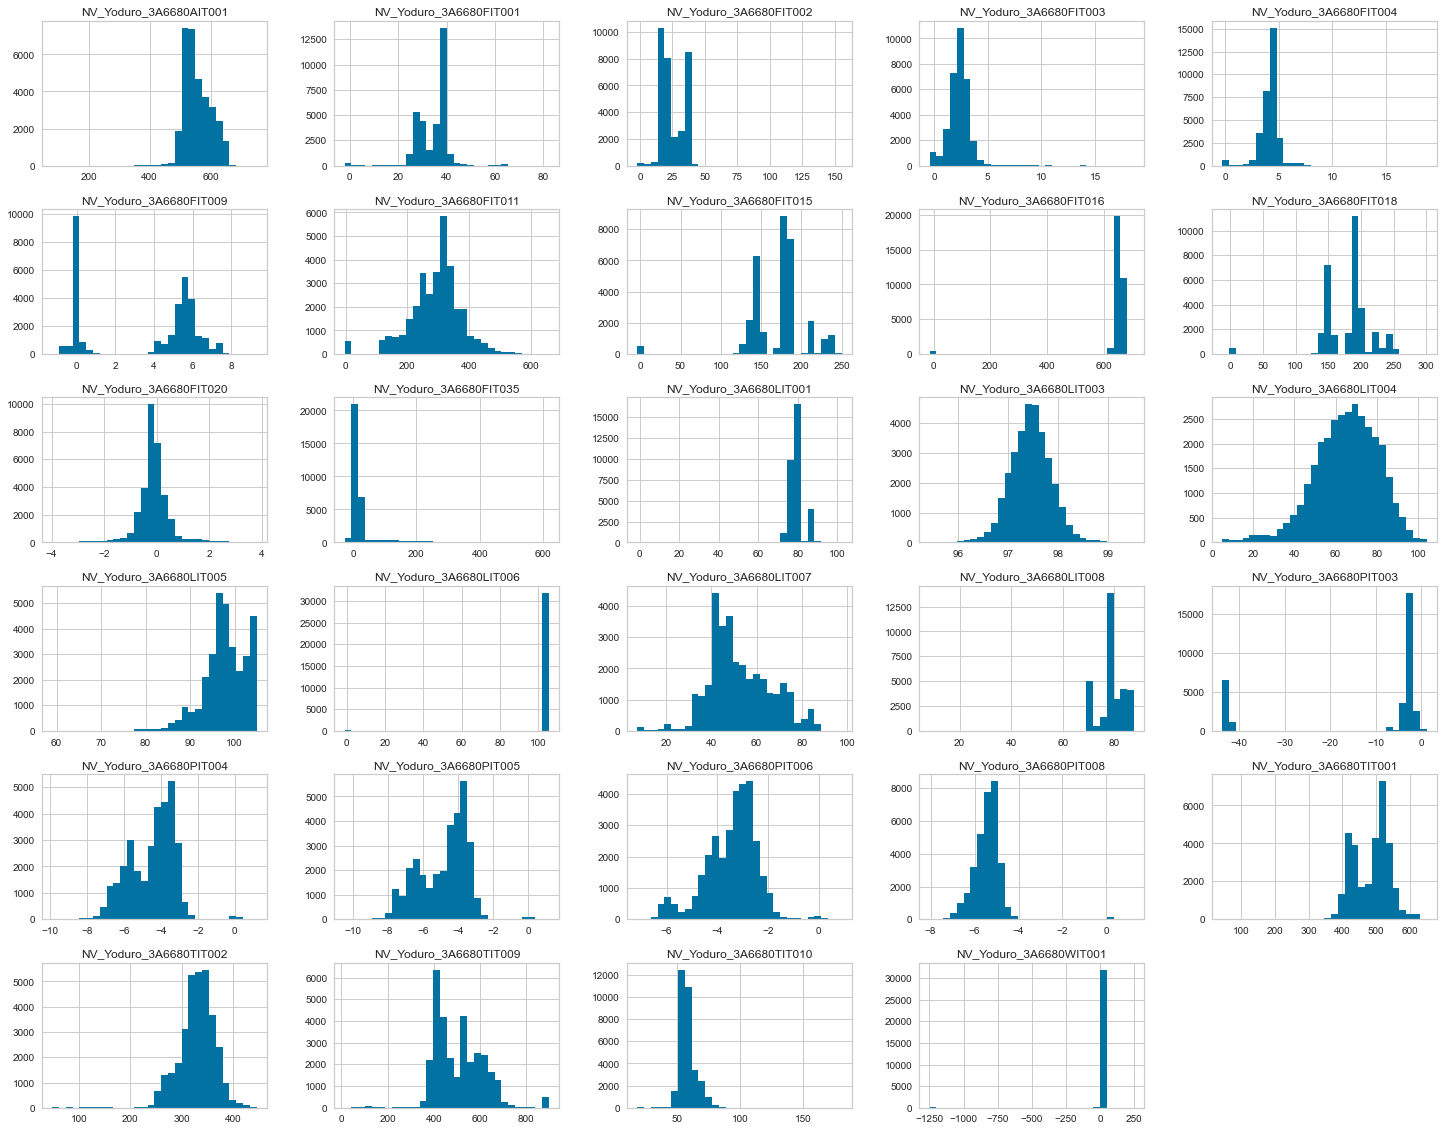

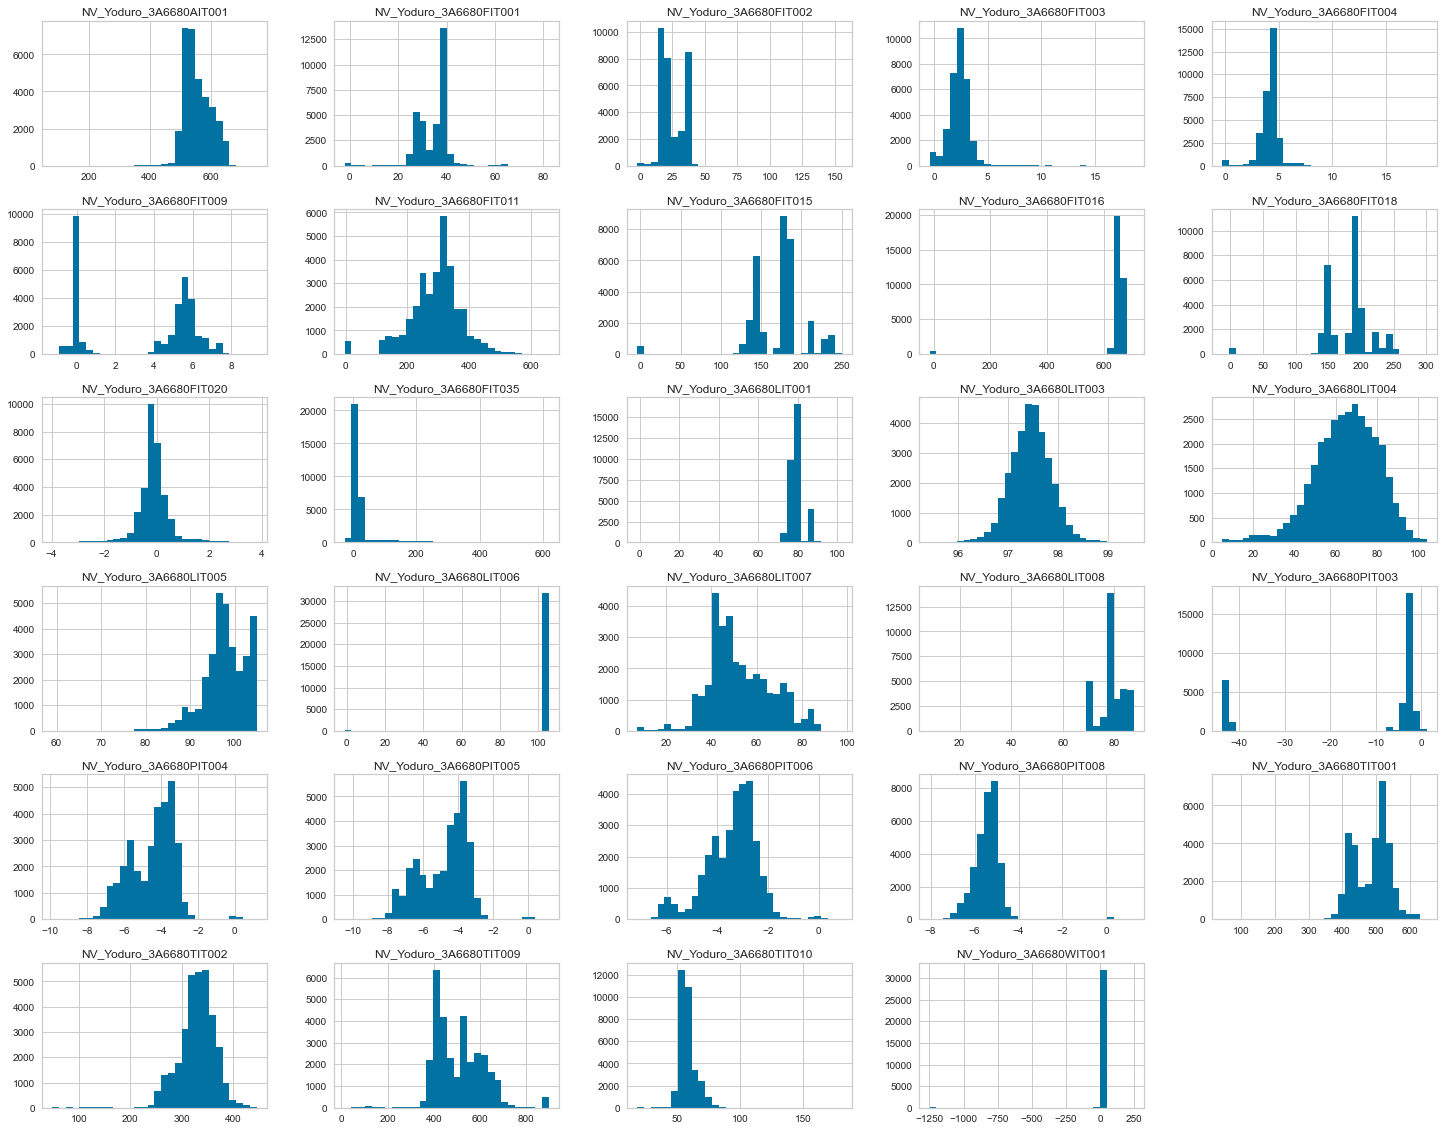

In [51]:
# The distribution for the rest of the variables is displayed

axes = dataset_training.drop(columns=["TIMESTAMP"]).hist(bins=30, figsize=(25, 20))
dataset_training.drop(columns=["TIMESTAMP"]).hist(bins=30, figsize=(25, 20));

In [56]:
row_delta = 2

# The data in the downstream variable columns is shifted (excluding the output column (ORP) and the timestamp)
for col in dataset_training.columns:
    if col not in ['TIMESTAMP', 'NV_Yoduro_3A6680AIT001']:
        dataset_training[col] = dataset_training[col].shift(row_delta)

# Rows with null values generated by the shift are removed
dataset_training = dataset_training.dropna().reset_index(drop=True)

# We review the dataframe
dataset_training.head()

,TIMESTAMP,NV_Yoduro_3A6680AIT001,NV_Yoduro_3A6680FIT001,NV_Yoduro_3A6680FIT002,NV_Yoduro_3A6680FIT003,NV_Yoduro_3A6680FIT004,NV_Yoduro_3A6680FIT009,NV_Yoduro_3A6680FIT011,NV_Yoduro_3A6680FIT015,NV_Yoduro_3A6680FIT016,...,NV_Yoduro_3A6680PIT003,NV_Yoduro_3A6680PIT004,NV_Yoduro_3A6680PIT005,NV_Yoduro_3A6680PIT006,NV_Yoduro_3A6680PIT008,NV_Yoduro_3A6680TIT001,NV_Yoduro_3A6680TIT002,NV_Yoduro_3A6680TIT009,NV_Yoduro_3A6680TIT010,NV_Yoduro_3A6680WIT001
0,2022-03-18 04:19:00,538.990601,64.818748,33.665627,2.661750,4.855500,5.078125,284.080933,145.294739,663.5000,...,-2.645626,-7.203751,-7.559689,-3.214062,-5.089375,608.150024,399.549988,662.200012,61.174999,2.408529
1,2022-03-18 04:29:00,534.516968,62.971874,33.346874,2.665125,4.807125,4.750000,283.303650,145.503311,660.1875,...,-2.576561,-6.980625,-7.421562,-3.129063,-4.542187,607.849976,392.850006,661.599976,62.500000,2.322643
2,2022-03-18 04:34:00,529.187561,62.981251,34.209373,1.423125,4.819500,4.440625,271.437012,145.492538,665.8750,...,-2.518124,-7.182499,-7.655312,-3.245937,-5.014999,607.150024,390.100006,665.450012,62.325001,2.647246
3,2022-03-18 04:39:00,550.872070,63.309376,34.049999,0.784125,4.839750,5.384375,265.827148,145.606583,666.6875,...,-2.937813,-7.256874,-8.011250,-3.856876,-4.887501,606.900024,390.399994,661.950012,62.125000,2.718205
4,2022-03-18 04:44:00,534.452393,63.590626,33.806252,1.410750,4.801500,5.403125,277.193848,145.454071,659.2500,...,-2.650936,-7.634064,-7.442814,-3.261875,-4.914062,607.299988,388.700012,884.950012,62.212502,2.282615


# Model

In [60]:
# We copy the dataframe in case we need to use it again
dataset_training_1=dataset_training.copy()
dataset_training_1.head()

,TIMESTAMP,NV_Yoduro_3A6680AIT001,NV_Yoduro_3A6680FIT001,NV_Yoduro_3A6680FIT002,NV_Yoduro_3A6680FIT003,NV_Yoduro_3A6680FIT004,NV_Yoduro_3A6680FIT009,NV_Yoduro_3A6680FIT011,NV_Yoduro_3A6680FIT015,NV_Yoduro_3A6680FIT016,...,NV_Yoduro_3A6680PIT003,NV_Yoduro_3A6680PIT004,NV_Yoduro_3A6680PIT005,NV_Yoduro_3A6680PIT006,NV_Yoduro_3A6680PIT008,NV_Yoduro_3A6680TIT001,NV_Yoduro_3A6680TIT002,NV_Yoduro_3A6680TIT009,NV_Yoduro_3A6680TIT010,NV_Yoduro_3A6680WIT001
0,2022-03-18 04:19:00,538.990601,64.818748,33.665627,2.661750,4.855500,5.078125,284.080933,145.294739,663.5000,...,-2.645626,-7.203751,-7.559689,-3.214062,-5.089375,608.150024,399.549988,662.200012,61.174999,2.408529
1,2022-03-18 04:29:00,534.516968,62.971874,33.346874,2.665125,4.807125,4.750000,283.303650,145.503311,660.1875,...,-2.576561,-6.980625,-7.421562,-3.129063,-4.542187,607.849976,392.850006,661.599976,62.500000,2.322643
2,2022-03-18 04:34:00,529.187561,62.981251,34.209373,1.423125,4.819500,4.440625,271.437012,145.492538,665.8750,...,-2.518124,-7.182499,-7.655312,-3.245937,-5.014999,607.150024,390.100006,665.450012,62.325001,2.647246
3,2022-03-18 04:39:00,550.872070,63.309376,34.049999,0.784125,4.839750,5.384375,265.827148,145.606583,666.6875,...,-2.937813,-7.256874,-8.011250,-3.856876,-4.887501,606.900024,390.399994,661.950012,62.125000,2.718205
4,2022-03-18 04:44:00,534.452393,63.590626,33.806252,1.410750,4.801500,5.403125,277.193848,145.454071,659.2500,...,-2.650936,-7.634064,-7.442814,-3.261875,-4.914062,607.299988,388.700012,884.950012,62.212502,2.282615


In [62]:
# We look for whether there is any linear relationship between attributes and the response variable
# positive correlation:
dataset_training_1.corr(method='pearson')["NV_Yoduro_3A6680AIT001"].sort_values(ascending=False)[:10]

NV_Yoduro_3A6680AIT001    1.000000
NV_Yoduro_3A6680FIT035    0.285882
NV_Yoduro_3A6680PIT006    0.260688
NV_Yoduro_3A6680PIT005    0.259368
NV_Yoduro_3A6680PIT004    0.249853
NV_Yoduro_3A6680LIT003    0.203640
NV_Yoduro_3A6680FIT009    0.183517
NV_Yoduro_3A6680FIT015    0.171579
NV_Yoduro_3A6680FIT018    0.161923
NV_Yoduro_3A6680LIT004    0.097623
Name: NV_Yoduro_3A6680AIT001, dtype: float64

In [54]:
# We look for whether there is any linear relationship between attributes and the response variable
# negative correlation:
dataset_training_1.corr(method='pearson')["NV_Yoduro_3A6680AIT001"].sort_values(ascending=False)[-10:]

NV_Yoduro_3A6680WIT001   -0.095672
NV_Yoduro_3A6680LIT008   -0.110836
NV_Yoduro_3A6680FIT002   -0.146388
NV_Yoduro_3A6680FIT011   -0.181069
NV_Yoduro_3A6680FIT001   -0.187263
NV_Yoduro_3A6680TIT010   -0.223276
NV_Yoduro_3A6680PIT003   -0.273877
NV_Yoduro_3A6680TIT002   -0.291286
NV_Yoduro_3A6680TIT009   -0.320062
NV_Yoduro_3A6680TIT001   -0.352490
Name: NV_Yoduro_3A6680AIT001, dtype: float64

## Model selection

In [63]:
# The TIMESTAMP column is eliminated, which does not give us relevant information as a regressor
dataset_training_1.drop(columns=["TIMESTAMP"],inplace=True)

In [64]:
# We set the model configuration
setup_modelo = setup(data = dataset_training_1, target = 'NV_Yoduro_3A6680AIT001',imputation_type='simple',
                    numeric_imputation='mean')

,Description,Value
0,Session id,426
1,Target,NV_Yoduro_3A6680AIT001
2,Target type,Regression
3,Original data shape,"(32270, 29)"
4,Transformed data shape,"(32270, 29)"
5,Transformed train set shape,"(22589, 29)"
6,Transformed test set shape,"(9681, 29)"
7,Numeric features,28
8,Preprocess,True
9,Imputation type,simple


In [65]:
# We run model benchmarking
regression_model=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,17.5818,606.5680,24.6219,0.6726,0.0458,0.0318,5.4170
rf,Random Forest Regressor,18.3929,650.7470,25.5050,0.6489,0.0472,0.0333,14.7820
lightgbm,Light Gradient Boosting Machine,20.6362,751.3501,27.4056,0.5945,0.0504,0.0373,0.2990
knn,K Neighbors Regressor,18.9882,751.9113,27.4163,0.5943,0.0504,0.0344,0.1330
gbr,Gradient Boosting Regressor,24.3302,974.1975,31.2089,0.4742,0.0570,0.0439,4.2230
dt,Decision Tree Regressor,24.3430,1291.4196,35.9240,0.3029,0.0665,0.0440,0.2950
lr,Linear Regression,29.0227,1353.9668,36.7924,0.2694,0.0667,0.0523,2.6740
ridge,Ridge Regression,29.0227,1353.9663,36.7924,0.2694,0.0667,0.0523,0.0240
br,Bayesian Ridge,29.0321,1353.9614,36.7924,0.2694,0.0667,0.0523,0.0260
lasso,Lasso Regression,29.3155,1367.8046,36.9807,0.2619,0.0670,0.0528,0.0470


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Good results are obtained and as the best model we have an Extra Trees Regressor

## Predictions on Training Set

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.2984,181.1222,13.4582,0.9015,0.0244,0.0095


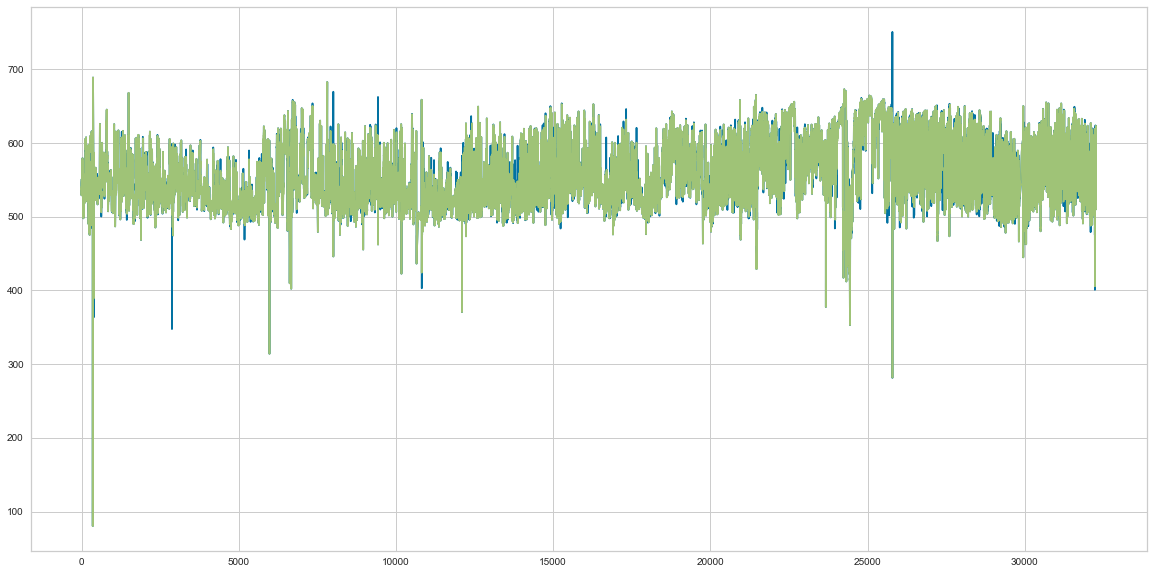

In [58]:
# The training series and the predictions on the same set are plotted

predictions=predict_model(regression_model,data=dataset_training_1)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(predictions['NV_Yoduro_3A6680AIT001'])
ax.plot(predictions['prediction_label'])

## Predictions on Holdout Set

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,17.6614,603.7405,24.5711,0.6692,0.0446,0.0318


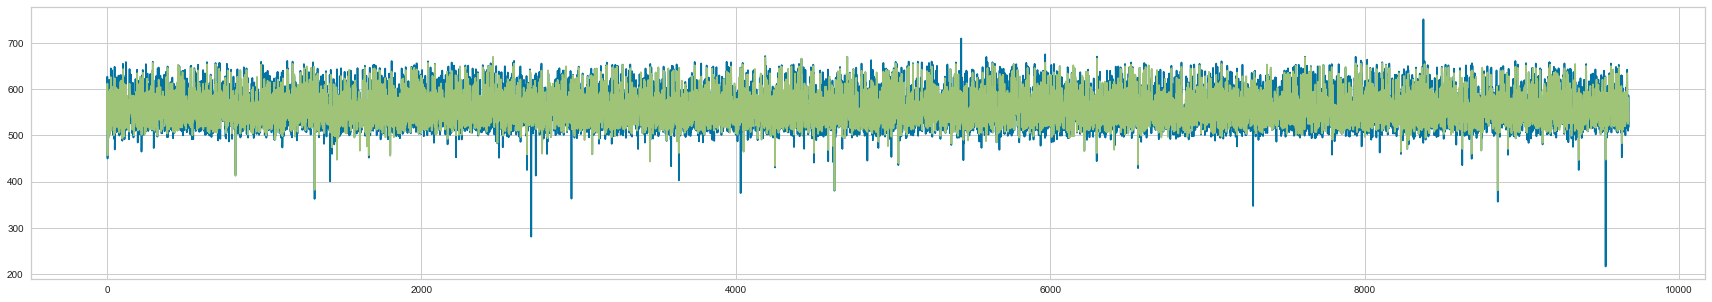

In [59]:
# The validation series and the predictions are plotted

predictions=predict_model(regression_model)
predictions = predictions.reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.plot(predictions['NV_Yoduro_3A6680AIT001'])
ax.plot(predictions['prediction_label'])

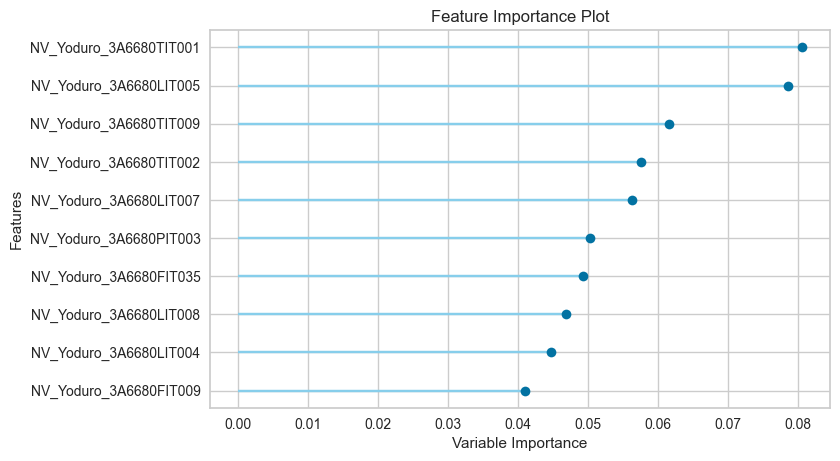

In [60]:
# The importance of the attributes of the regression model is observed
plot_model(regression_model,plot='feature')

The contribution of the TIT001 sensor in the predictions is observed

## Saving the Mode

In [61]:
# # Export preprocessed feature set (X) to CSV for model predictions
# The target variable (y) is excluded
get_config('X').to_csv("training_holdout_features.csv",index=False)

In [62]:
# Save the trained regression model as a .sav file for future use
filename = 'reg_model_ORP.sav'
pickle.dump(regression_model, open(filename, 'wb'))